In [1]:
from imports import *

In [2]:
def discard_border(state,t):
    state.start = state.start + (t * 1_000_000)
    state.end = state.end - (t * 1_000_000)

In [3]:
def firing_rates_intervals(neurons,intervals,nbins):
    if len(intervals) == 0:
        firing_rates = np.empty(shape = (len(neurons),nbins))
        firing_rates.fill(np.nan)
        return firing_rates

    intervals_activity_matrix = []
    for s,e in tqdm(intervals.as_units('s').iloc(),total = len(intervals)):
        inter = nts.IntervalSet(s,e,time_units='s')
        bin_size = inter.duration(time_units='s')/nbins
        t,binned = bk.compute.binSpikes(neurons,start = s,stop = e,nbins = nbins)
        binned = binned/bin_size

        intervals_activity_matrix.append(binned)
    return np.mean(intervals_activity_matrix,0)

def mean_firing_rates_intervals(neurons,intervals,name = None):
    firing_rates = []
    for n in neurons:
        fr = len(n.restrict(intervals))/intervals.tot_length(time_units = 's')
        firing_rates.append(fr)
    if name is None: name = 'FR'   
    firing_rates = pd.DataFrame(firing_rates,columns=[name])
    return firing_rates

In [12]:
def main(base_folder, local_path, *args, **kwargs):

    nbins = kwargs['nbins']
    min_duration_epoch = kwargs['min_duration']
    time_from_border = kwargs['time_from_border']

    bk.load.current_session_linux(base_folder=base_folder,local_path=local_path)
    neurons,metadata = bk.load.spikes()
    states = bk.load.states(True)
    sleep = states['REM'].union(states['NREM'])

    for s in ['wake','drowsy']: states.pop(s)

    all_average_firing = {}
    for k,state in states.items():
        discard_border(state,time_from_border[k]) # We remove what is close to transition as the sleep scoring might not be perfect
        state = state.drop_short_intervals(min_duration_epoch[k],'s').reset_index(drop = True)
        all_average_firing.update({k:firing_rates_intervals(neurons,state,nbins[k])})

    fr = mean_firing_rates_intervals(neurons,sleep,'FR_sleep')
    metadata = pd.concat((metadata,fr),1)
    return all_average_firing,metadata

def merging(batch_output):
    states_activity = {'REM':[],
                        'NREM':[],
                        'WAKE_HOMECAGE':[]}
    metadata = pd.DataFrame()
    for k,b in batch_output.items():
        metadata = pd.concat((metadata,b[1]))
        for kk,state_activity in b[0].items():
            states_activity[kk].append(state_activity)
    
    for k,state_activity in states_activity.items():
        states_activity[k] = np.vstack(state_activity)
    return states_activity,metadata

def plot(activity,metadata,norm = True,order = None,quintile = False,ax = None,style = '',ylim = (-1,1)):

    if style == '': style = 'k--'
    if norm:
        activity = zscore(activity,1)
    if order == 'fr':
        order = np.argsort(metadata.FR_sleep)
        activity = activity[order,:]
        metadata = metadata.iloc[order]
    if order == 'delta':
        delta = np.mean(activity[:,-11:-1],1) - np.mean(activity[:,0:9],1)
        order = np.argsort(delta)
        activity = activity[order,:]
        metadata = metadata.iloc[order]


    if ax is None: fig, ax = plt.subplots(1,2)
    ax[0].imshow(activity,aspect = 'auto',interpolation='bilinear')
    for im in ax[0].get_images():
        im.set_clim(-2,2)
    
    
    if quintile:
        labels = ['Very Low','Low','Medium','High','Very High']
        labels_neurons = pd.qcut(metadata.FR_sleep,5,labels = labels)
        for label in labels:
            ax[1].plot(np.nanmean(activity[labels_neurons == label,:],0))
            ax[1].legend(labels)
    else:
        ax[1].plot(np.nanmean(activity,0),style)    
    ax[1].set_ylim(ylim)

def compute_activity_reg(activity):
    x = np.arange(activity.shape[1])
    x = np.tile(x,activity.shape[0])
    y = activity.flatten()

    # Get rid of nans that could be there
    y_nans = np.isnan(y)
    x = x[~y_nans]
    y = y[~y_nans]

    return scipy.stats.linregress(x,y),x,y

def plot_lin_reg(reg,xmin,xmax,step = 0.1,ax = None,style = ''):
    if ax is None:
        fig,ax = plt.subplots()
    
    x = np.arange(xmin,xmax,0.1)
    y = reg.slope * x + reg.intercept
    ax.plot(x,y,style)

def regress(activity,metadata,quintile,norm):
    if norm:
        activity = zscore(activity,1)
    
    if quintile:
        labels = ['Very Low','Low','Medium','High','Very High']
        labels_neurons = pd.qcut(metadata.FR_sleep,5,labels = labels)
        reg = {}
        x = {} 
        y = {}
        for label in labels:
            reg[label],x[label],y[label] = compute_activity_reg(activity[labels_neurons == label])
    else:
        reg,x,y = compute_activity_reg(activity)
    
    return reg,x,y

In [15]:
kwargs = {'nbins':
          {
              'REM': 12,
              'NREM': 30,
              'WAKE_HOMECAGE': 30
          },
          'min_duration':
          {
              'REM': 50,
              'NREM': 250,
              'WAKE_HOMECAGE': 250
          },
          'time_from_border':
          {'REM': 10,
           'NREM': 20,
           'WAKE_HOMECAGE': 10
           }
          }
# batch_output_60, batch_metadata_60 = bk.load.batch(main, **kwargs)
# states_activity, metadata = merging(batch_output_60)


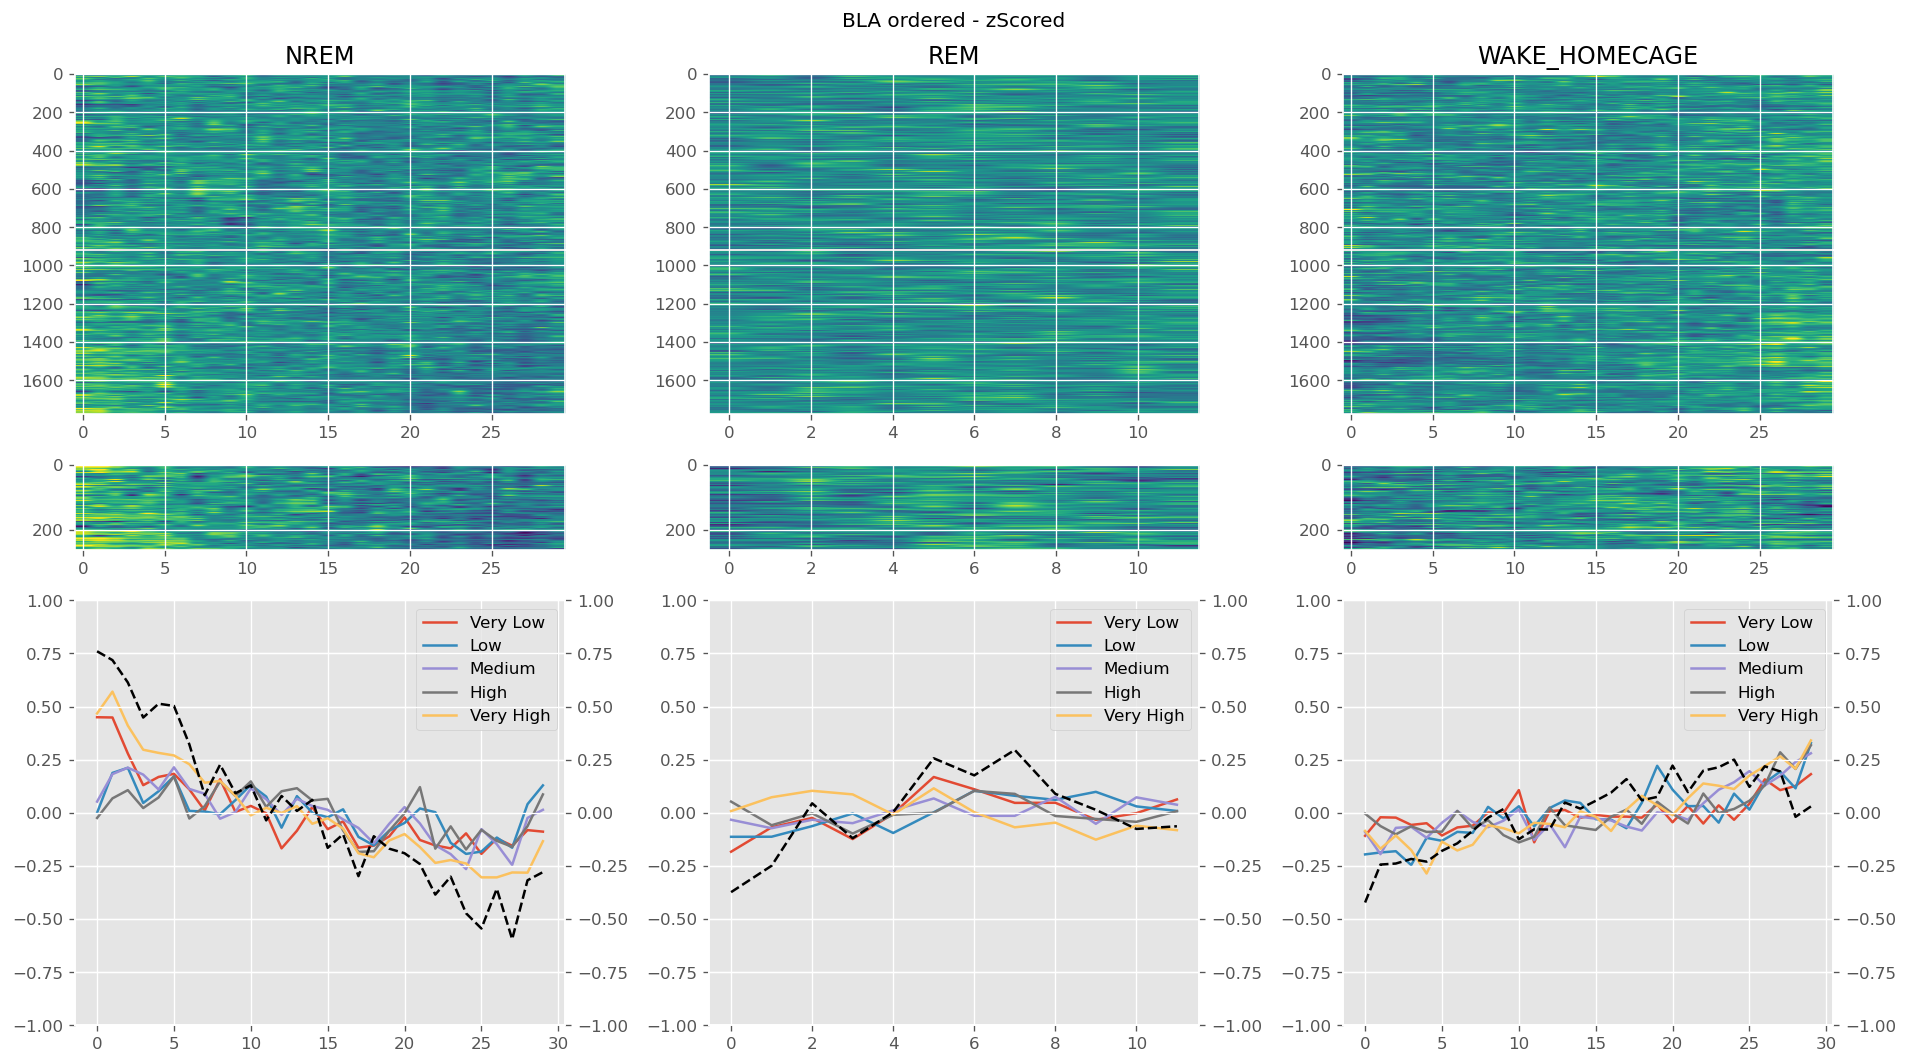

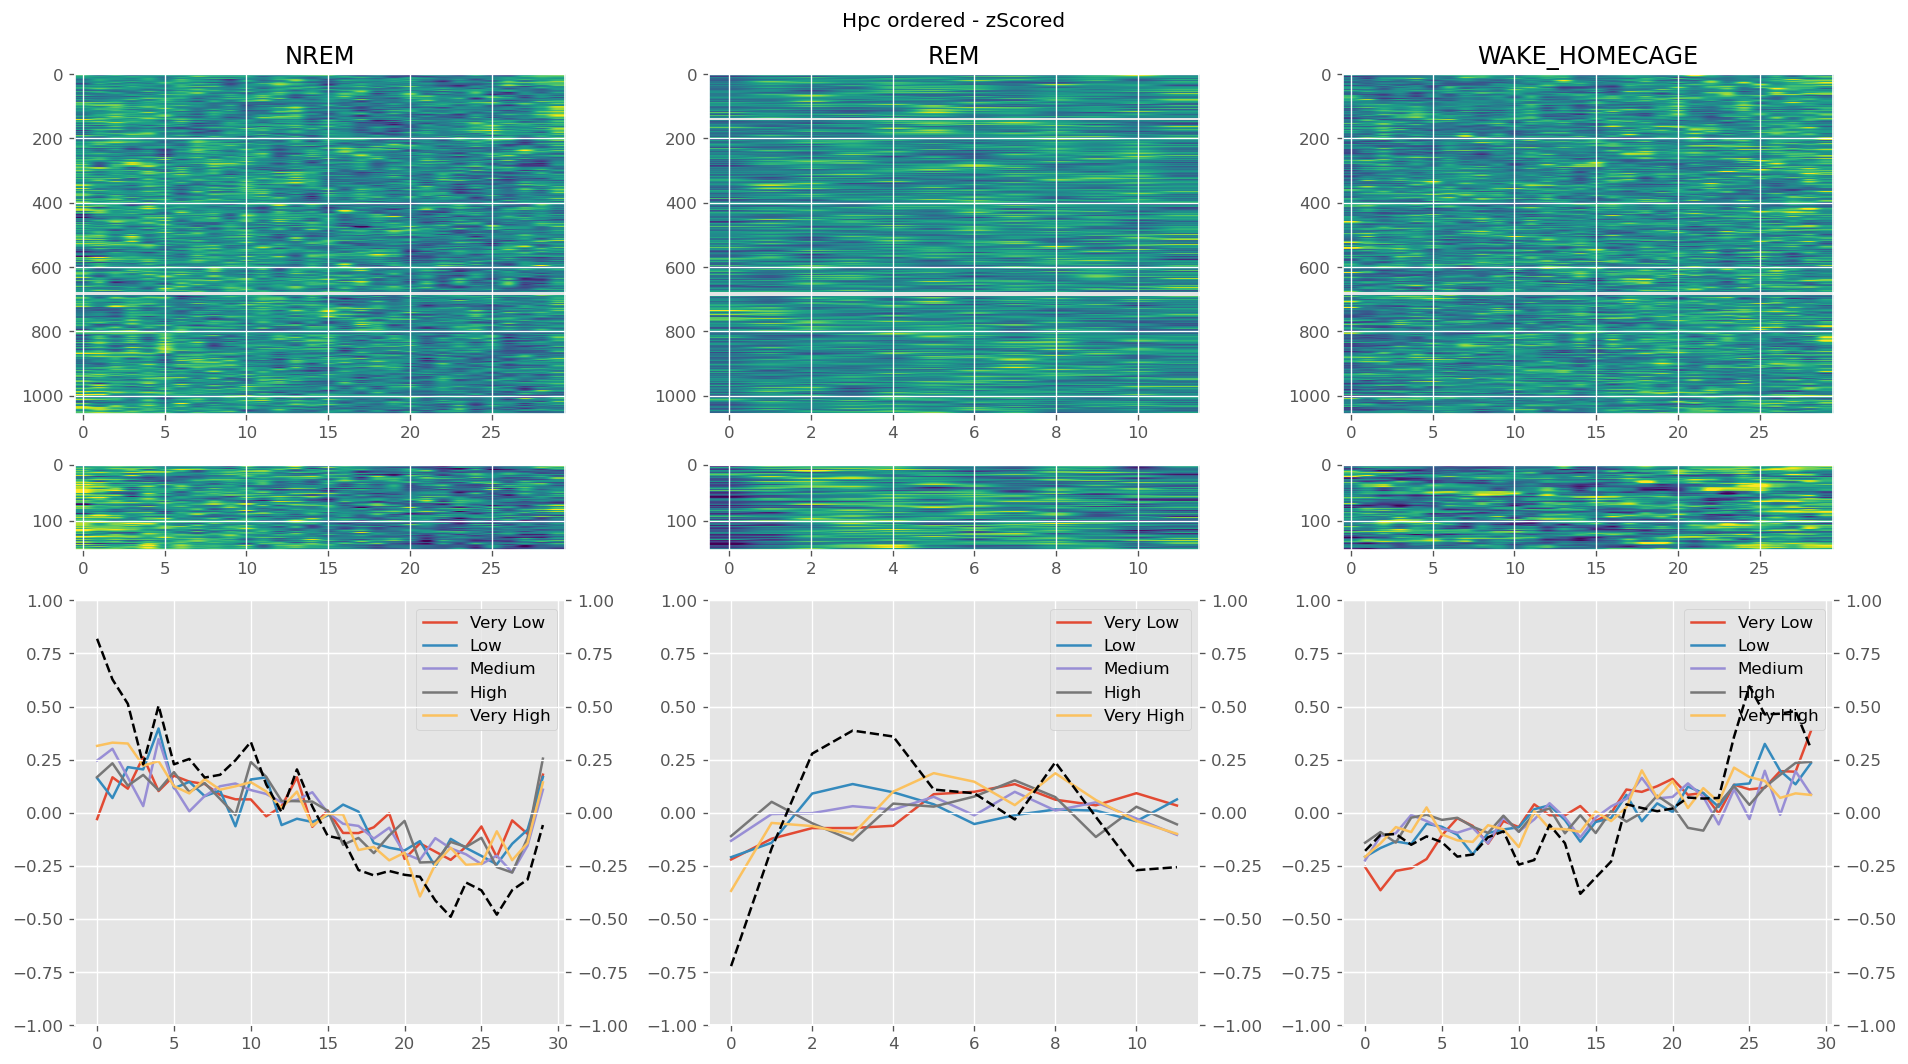

In [16]:
# metadata.Type[metadata.Region == 'CeCM'] = 'Int'
for stru in np.unique(['Hpc','BLA']):
    fig,ax = plt.subplots(3,3,gridspec_kw = {'height_ratios':[4,1,5]},figsize =(16,9),dpi = 120)
    for i,state in enumerate(['NREM','REM','WAKE_HOMECAGE']):
        mask_pyr = (metadata.Region == stru) & (metadata.Type == 'Pyr') 
        mask_int = (metadata.Region == stru) & (metadata.Type == 'Int') 
        ax_int = ax[2,i].twinx()
        if np.any(mask_pyr):
            plot(states_activity[state][mask_pyr],metadata[mask_pyr],
                norm = True,
                order = 'FR',
                quintile = True,
                ax = [ax[0,i],ax[2,i]],
                style = 'g--',
                ylim = [-1,1])
        if np.any(mask_int):
            plot(states_activity[state][mask_int],metadata[mask_int],
                norm = True,
                order = 'FR',
                quintile = False,
                ax = [ax[1,i],ax_int])

        plt.suptitle(f'{stru} ordered - zScored')
        plt.sca(ax[0,i])
        plt.title(f'{state}')
        plt.tight_layout()
    # plt.savefig(f'/home/billel/pCloudDrive/IFM/work/Figures/ByFindings/BLA_Firing_Within_States/{stru}.svg')
    # plt.savefig(f'/home/billel/pCloudDrive/IFM/work/Figures/Figures_Gabrielle/states/dynamic/{stru}.png')

In [25]:
batch_metadata_60

,Rat,Day
Rat08-20130708,8,1
Rat08-20130709,8,2
Rat08-20130710,8,3
Rat08-20130711,8,4
Rat08-20130712,8,5
Rat08-20130713,8,6
Rat08-20130715,8,7
Rat08-20130716,8,8
Rat08-20130717,8,9
Rat08-20130718,8,10


In [19]:
all_fr = pd.read_csv(f'{bk.load.base}/All-Rats/States/fr_states.csv')

In [21]:
all_fr

,Rat,Day,Shank,Id,Region,Type,wake,drowsy,WAKE_HOMECAGE,NREM,REM,SLEEP
0,8,1,4,2,Hpc,Pyr,0.553571,0.371076,0.604555,0.873333,1.995636,1.038426
1,8,1,4,3,Hpc,Pyr,0.689208,0.933857,0.749210,0.725484,0.658978,0.715701
2,8,1,4,4,Hpc,Int,0.265140,0.178251,0.334955,0.398710,0.304863,0.384905
3,8,1,4,5,Hpc,Pyr,1.005745,1.386771,1.278268,1.118065,0.517456,1.029714
4,8,1,4,6,Hpc,Pyr,0.488509,0.815022,0.586920,0.384409,0.314214,0.374083
...,...,...,...,...,...,...,...,...,...,...,...,...
6700,11,20,18,14,Hpc,Pyr,2.695594,4.007692,2.887911,1.320266,0.655777,1.195107
6701,11,20,18,15,Hpc,Int,9.263293,8.361538,9.062679,8.589497,5.254980,7.961429
6702,11,20,20,2,Hpc,Pyr,3.335514,1.761538,3.267870,2.153476,7.678884,3.194207
6703,11,20,20,3,Hpc,Pyr,0.302867,0.269231,0.286652,2.248706,2.733865,2.340087


In [24]:
len(batch_output_60)

57

# Plot LinReg for each quintiles of Pyr BLA neurons

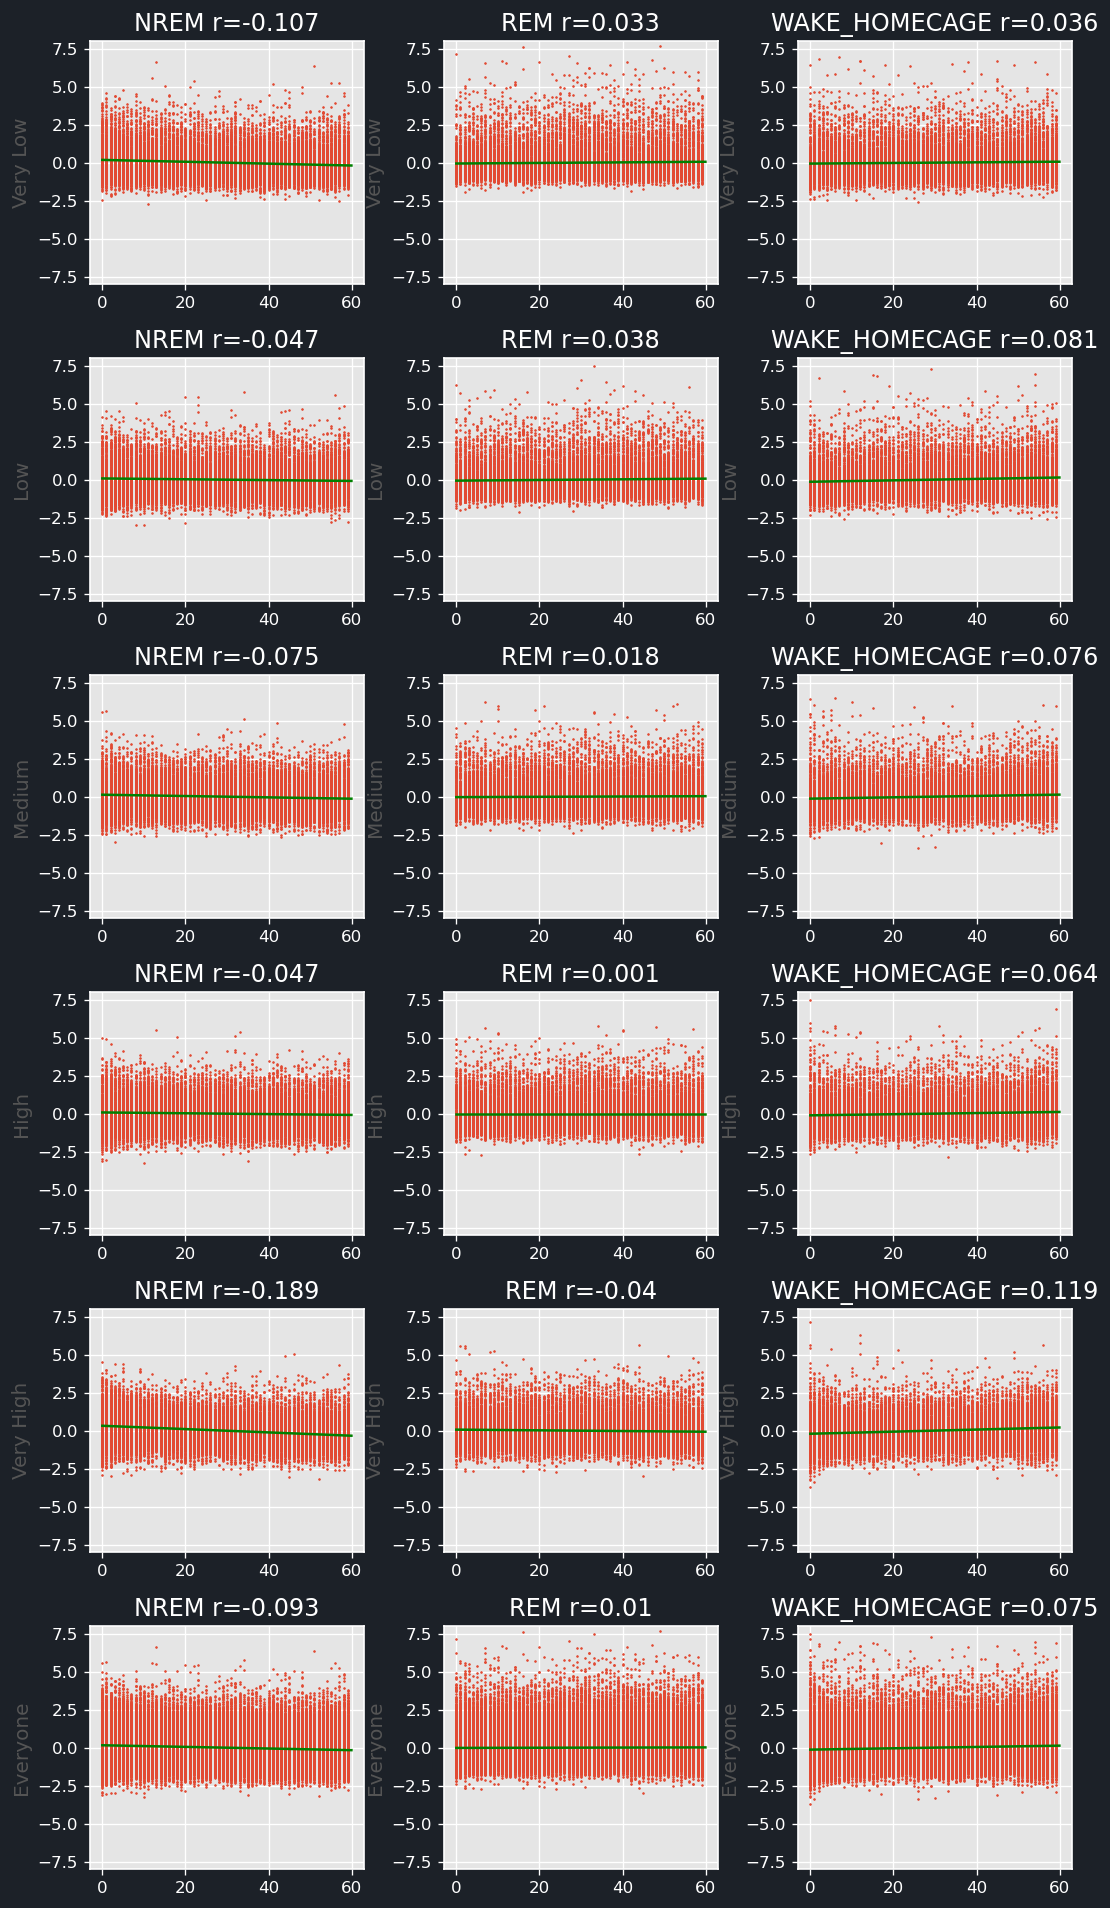

In [144]:
fig,ax = plt.subplots(6,3,figsize =(9,16),dpi = 120) 
stru = 'BLA'
for i,state in enumerate(['NREM','REM','WAKE_HOMECAGE']):
    mask_pyr = (metadata.Region == stru) & (metadata.Type == 'Pyr') 
    reg,x,y = regress(states_activity[state][mask_pyr,:],metadata[mask_pyr],True,True)
    for j,q in enumerate(reg):
        ax[j,i].scatter(x[q],y[q],s = 1)
        plot_lin_reg(reg[q],0,60,0.1,ax[j,i],'g')
        ax[j,i].set_ylim(-8,8)
        ax[j,i].set_ylabel(q)
        ax[j,i].set_title(f'{state} r={np.round(reg[q].rvalue,3)}')
    
    reg,x,y = regress(states_activity[state][mask_pyr,:],metadata[mask_pyr],False,True)
    ax[5,i].scatter(x,y,s = 1)
    plot_lin_reg(reg,0,60,0.1,ax[5,i],'g')
    ax[5,i].set_ylim(-8,8)
    ax[5,i].set_ylabel('Everyone')
    ax[5,i].set_title(f'{state} r={np.round(reg.rvalue,3)}')
plt.tight_layout()